# Getting started with the BRIDGE dataset

This notebook walks through some examples of how to use the tabular MDPs in the BRIDGE dataset.

If you are running this notebook in Google Colab, it is recommended to use a GPU. You can enable GPU acceleration by going to Runtime > Change runtime type and selecting GPU from the dropdown.

First, install the `effective-horizon` package, either from the local repository or from PyPI:

In [1]:
import os
import warnings

if os.path.exists("pyproject.toml"):
    !pip install -e .
else:
    !pip install effective-horizon

!pip install requests matplotlib

warnings.warn = lambda *args,**kwargs: None

Obtaining file:///home/cassidy/sh/Programs/Python/effective-horizon
  Installing build dependencies ... - \ | done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... - done
  Installing backend dependencies ... - \ done
  Preparing editable metadata (pyproject.toml) ... - done
  Building editable for effective-horizon (pyproject.toml) ... - done
  Created wheel for effective-horizon: filename=effective_horizon-0.1.0-0.editable-py3-none-any.whl size=8584 sha256=4fabfcc6351b56a7b31c00dbde8b0290571ef2fc65de52b12eb6a852ed97c303
  Stored in directory: /tmp/pip-ephem-wheel-cache-37o4_8oj/wheels/41/59/be/6f885a1d514659d5ee63e55292b47bd8503f7ed6bc71c33d69
Successfully built effective-horizon
  Attempting uninstall: effective-horizon
    Found existing installation: effective-horizon 0.1.0
    Uninstalling effective-horizon-0.1.0:
      Successfully uninstalled effective-horizon-0.1.0


First, let's load a tabular version of an MDP. The repository includes a few small MDPs, but the rest are included in the [full BRIDGE dataset](https://zenodo.org/records/10966777). The `load_mdp` function will load transitions and rewards matrices.

In [2]:
from effective_horizon.mdp_utils import load_mdp

from io import BytesIO
import requests

mdp_file = "data/mdps/MiniGrid-KeyCorridorS3R1-v0/consolidated.npz"
if not os.path.exists(mdp_file):
    response = requests.get("https://github.com/cassidylaidlaw/effective-horizon/raw/main/data/mdps/MiniGrid-KeyCorridorS3R1-v0/consolidated.npz", stream=True)
    mdp_file = BytesIO(response.raw.read())

transitions, rewards = load_mdp(mdp_file)
transitions.shape, rewards.shape, transitions[0]

((169, 6), (169, 6), array([ 82, 156,   0,   0,   0,   0]))

Both the `transitions` and `rewards` matrices are of size `(num_states, num_actions)`. As we can see, this MDP has 158 states (157 non-terminal states plus the terminal state) and 6 actions. `transitions[0]` gives the states that are reached by taking each action in the initial state, which is always at index 0.

Now, let's use value iteration to determine an optimal policy for this MDP.

In [3]:
from effective_horizon.mdp_utils import get_sparse_mdp, run_value_iteration

import numpy as np

sparse_transitions, rewards_vector = get_sparse_mdp(transitions, rewards)
vi_results = run_value_iteration(sparse_transitions, rewards_vector, horizon=100)

optimal_policy = np.argmax(vi_results.optimal_qs, axis=2)
print(optimal_policy.shape)

total_reward = 0
optimal_actions = []
state = 0
for t in range(100):
    action = optimal_policy[t, state]
    optimal_actions.append(action)
    reward = rewards[state, action]
    total_reward += reward
    state = transitions[state, action]
total_reward, vi_results.optimal_values[0, 0]

(100, 169)


Value iteration: 100%|██████████| 100/100 [00:00<00:00, 5006.69it/s]


(1.0, 1.0)

`run_value_iteration` returns the optimal Q and value functions as well as the random policy's Q and value functions (which can be accessed by `vi_results.random_qs`). By taking the arg-max of the optimal Q function, we can get an optimal policy. Running this optimal policy in the environment gives reward equal to the optimal value at the initial state.

We can also access the same environment through the [Gymnasium](https://gymnasium.farama.org/) API:

In [4]:
import effective_horizon
import gymnasium as gym

env = gym.make("BRIDGE/MiniGrid-KeyCorridorS3R1-v0")
obs, info = env.reset()

total_reward = 0
for t in range(100):
    action = optimal_actions[t]
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated:
        break

print(total_reward)

1.0


The tabular and Gymnasium versions of the environments are identical, as shown by the fact that the optimal policy calculated from the tabular version also achieves optimal return in the Gymnasium environment. The Gymnasium environments can be used to run deep RL algorithms and compare their results to properties computed from the tabular versions!

For visualization purposes, it's also possible to view what the screen observation looks like for a particular state in the tabular MDP. For example, let's find which state has the lowest non-zero value under the random policy:

84 39 5.671526e-12


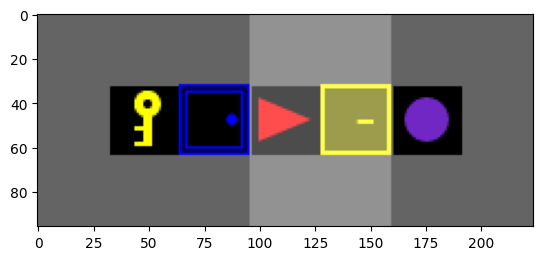

In [5]:
import numpy as np
import matplotlib.pyplot as plt

t, state = np.unravel_index(
    np.argmin(np.where(vi_results.random_values > 0, vi_results.random_values, np.inf)),
    vi_results.random_values.shape,
)
print(t, state, vi_results.random_values[t, state])

mdp = np.load(mdp_file)
plt.imshow(mdp["screens"][mdp["screen_mapping"][state]])

At this state on the 85th timestep, there is less than a $10^{-11}$ chance of getting the optimal reward!

We can even load the state of the MDP from the tabular version into the Gym environment:

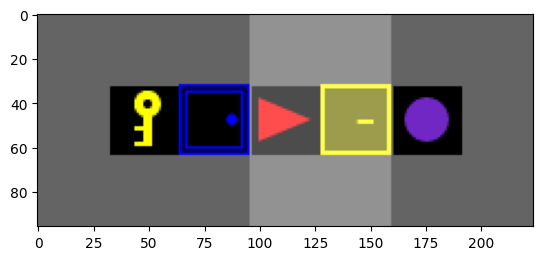

In [6]:
state_bytes = mdp["states"][state, :mdp["state_lengths"][state]].tobytes()
env.unwrapped.render_mode = "rgb_array"
env.set_state(state_bytes)
plt.imshow(env.render())

As we can see, we get the same image as in the tabular version.

That's it for this quick introduction to the BRIDGE dataset! While all the tabular environments in the dataset have transition and reward matrices, only the smaller ones have screen images and states, since they would be prohibitively large for environments with many states.